In [2]:
import numpy as np
import scipy.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, pickle

import geomstats.backend as gs
import geomstats.errors as error
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import (
    SPDMatrices,
    SPDAffineMetric,
    SPDLogEuclideanMetric,
    SPDBuresWassersteinMetric
)
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian
import geomstats.visualization as visualization
from geomstats.visualization import Sphere

import sys
sys.path.append(os.path.join(os.getcwd(),'../..'))
import riemannian_robust_m_estimator as rrm



In [3]:
def geodetic_to_cartesian(lat_deg, lon_deg, r=1.0):
    """위도/경도(도) -> 3D 좌표(x,y,z), r은 반지름(또는 고도 포함 반경)."""
    lat = np.deg2rad(lat_deg)
    lon = np.deg2rad(lon_deg)
    clat = np.cos(lat)
    x = r * clat * np.cos(lon)
    y = r * clat * np.sin(lon)
    z = r * np.sin(lat)
    return np.stack([x, y, z], axis=-1)


def wrap_lon_deg(lon):
    # [-180, 180) 범위로 정규화
    return ((lon + 180.0) % 360.0) - 180.0

def vgp_from_site_DI(lat_site_deg, lon_site_deg, D_deg, I_deg, north_convention=False):
    # deg -> rad
    φ = np.radians(lat_site_deg)
    λ = np.radians(lon_site_deg)
    D = np.radians(D_deg)
    I = np.radians(I_deg)

    # 중심각 Δ (GAD)
    Δ = np.radians(90.0) - np.arctan(0.5 * np.tan(I))

    # 목적점(대권 전진) 공식을 이용한 VGP 위도/경도
    sin_φp = np.sin(φ) * np.cos(Δ) + np.cos(φ) * np.sin(Δ) * np.cos(D)
    φp = np.arcsin(np.clip(sin_φp, -1.0, 1.0))
    Δλ = np.arctan2(np.sin(Δ) * np.sin(D),
                    np.cos(φ) * np.cos(Δ) - np.sin(φ) * np.sin(Δ) * np.cos(D))
    λp = λ + Δλ

    lat_vgp = np.degrees(φp)
    lon_vgp = wrap_lon_deg(np.degrees(λp))

    if north_convention:
        mask = (I_deg < 0)  # 역자극(상향) 관측치
        lat_vgp = np.array(lat_vgp, copy=True)
        lon_vgp = np.array(lon_vgp, copy=True)
        lat_vgp[mask] = -lat_vgp[mask]
        lon_vgp[mask] = wrap_lon_deg(lon_vgp[mask] + 180.0)

    return lat_vgp, lon_vgp

In [27]:
vgps =  pd.read_csv('vgps_filtered.csv')
vgps_sites = geodetic_to_cartesian(vgps.slat, vgps.slon, r=1.0)
lat_vgp, lon_vgp = vgp_from_site_DI(vgps.slat,vgps.slon,vgps.dec,vgps.inc)
vgps['lat_vgp_a'] = lat_vgp
vgps['lon_vgp_a'] = lon_vgp
vgp_cal = geodetic_to_cartesian(lat_vgp, lon_vgp, r=1.0)
vgp_df = geodetic_to_cartesian(vgps.VGP_lat, vgps.VGP_lon, r=1.0)
vgps.iloc[:5,:15]

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp
0,TL1,Tequila volcanic field,20.804333,-103.7965,6.0,358.5,23.3,78.0,7.7,NaN,81.5,86.5,NaN,NaN,NaN
1,TL5,Tequila volcanic field,20.866000,-103.8400,3.0,359.7,22.9,56.0,8.8,NaN,81.4,78.5,NaN,NaN,NaN
2,TM3,Tequila volcanic field,20.810000,-103.8450,6.0,10.5,26.1,128.0,6.5,NaN,77.9,16.7,NaN,NaN,NaN
3,TM2,Tequila volcanic field,20.790170,-103.8510,5.0,345.6,41.5,61.0,8.9,NaN,76.2,183.4,NaN,NaN,NaN
4,TM1,Tequila volcanic field,20.789670,-103.8490,6.0,12.3,24.7,45.0,9.9,NaN,76.0,17.1,NaN,NaN,NaN


In [12]:
vgps.loc[[26,185,186,189, 221, 222, 223, 224, 225, 226, 227, 228,],
         ['VGP_lat', 'VGP_lon','VGP_lat_recalc','VGP_lon_recalc','vgp_lat_SH', 'vgp_lon_SH','lat_vgp_a','lon_vgp_a']] #.loc[:,:60]

,VGP_lat,VGP_lon,VGP_lat_recalc,VGP_lon_recalc,vgp_lat_SH,vgp_lon_SH,lat_vgp_a,lon_vgp_a
26,NaN,NaN,-76.840811,281.939029,-76.840811,281.939029,-76.840811,-78.060971
185,NaN,NaN,72.724981,194.225590,-72.724981,14.225590,72.724981,-165.774410
186,NaN,NaN,79.043999,256.526228,-79.043999,76.526228,79.043999,-103.473772
189,NaN,NaN,74.402450,269.727747,-74.402450,89.727747,74.402450,-90.272253
221,NaN,NaN,82.329470,129.989422,-82.329470,309.989422,82.329470,129.989422
222,NaN,NaN,78.413626,94.558585,-78.413626,274.558585,78.413626,94.558585
223,NaN,NaN,88.122826,47.149408,-88.122826,227.149408,88.122826,47.149408
224,NaN,NaN,69.992008,161.158047,-69.992008,341.158047,69.992008,161.158047
225,NaN,NaN,49.889048,149.235916,-49.889048,329.235916,49.889048,149.235916
226,NaN,NaN,56.077205,158.995345,-56.077205,338.995345,56.077205,158.995345


In [ ]:
sph = Hypersphere(2)
vgp_cal = vgp_cal[sph.belongs(vgp_cal)]
vgp_df = vgp_df[sph.belongs(vgp_df)]
print(vgp_cal.shape,vgp_df.shape)

(vgp_cal[:,2]>0).mean(),(vgp_df[:,2]>0).mean()

(np.float64(0.5504201680672269), np.float64(0.7764876632801161))

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

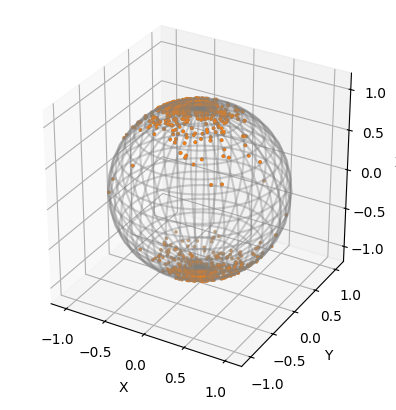

In [ ]:
visualization.plot(vgp_cal,space='S2',s=3)
visualization.plot(vgp_df,space='S2',s=3)

In [16]:
cities = [
    ("New York",        40.71,  -74.01),
    ("Washington DC",   38.90,  -77.04),
    ("London",          51.51,   -0.13),
    ("Paris",           48.85,    2.35),
    ("Berlin",          52.52,   13.40),
    ("Moscow",          55.76,   37.62),
    ("Beijing",         39.90,  116.40),
    ("Tokyo",           35.68,  139.76),
    ("Seoul",           37.57,  126.98),
    ("Singapore",        1.35,  103.82),
    ("Sydney",         -33.87,  151.21),
    ("Mumbai",          19.08,   72.88),
    ("São Paulo",      -23.55,  -46.63),
    ("Buenos Aires",   -34.61,  -58.38),
    ("Cape Town",      -33.93,   18.42),
    ("Nairobi",         -1.29,   36.82),
    ("Los Angeles",     34.05, -118.25),
    ("Chicago",         41.88,  -87.63),
    ("Mexico City",     19.43,  -99.13),
    ("Lima",           -12.05,  -77.05),
    ("Rio de Janeiro", -22.91,  -43.17),
    ("Lagos",            6.45,    3.39),
    ("Cairo",           30.04,   31.24),
    ("Istanbul",        41.01,   28.95),
    ("Dubai",           25.20,   55.27),
    ("New Delhi",       28.61,   77.21),
    ("Bangkok",         13.75,  100.50),
    ("Jakarta",         -6.21,  106.85),
    ("Melbourne",      -37.81,  144.96),
    ("Auckland",       -36.85,  174.76),
    ("Honolulu",        21.31, -157.86),
    ("Ankara",          39.93,   32.86),
]

# 라디안 변환
cities_rad = [(name,
               np.deg2rad(lat),
               np.deg2rad(lon)) for name, lat, lon in cities]

# S² 좌표 변환 (x,y,z)
points = []
names = []
for name, phi, lam in cities_rad:  # phi=위도(rad), lam=경도(rad)
    x = np.cos(phi) * np.cos(lam)
    y = np.cos(phi) * np.sin(lam)
    z = np.sin(phi)
    points.append([x, y, z])
    names.append(name)

points = np.array(points)

In [30]:
import matplotlib.cm as cm
cmap = cm.get_cmap('Set2')  

C:\Users\User\AppData\Local\Temp\ipykernel_40372\3486136310.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set2')


In [33]:
pd1 = sph.metric.dist_pairwise(vgp_df)
rx, cx = np.triu_indices(pd1.shape[0])
upper_pd1 = pd1[rx, cx]**2

mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
d_eff_est = (2 * mean_obs**2) / var_obs
# 공식: sigma^2 = E / (2 * d_eff)
sigma_sq_est = mean_obs / (2 * d_eff_est)
#rho_sq_est = (var_obs/4)/mean_obs
#cutoff_ = 0.75*np.sqrt(sigma_sq_est)
cutoff_ = 1.187*np.sqrt(sigma_sq_est)

In [35]:
0.7*np.sqrt(sigma_sq_est)

np.float64(0.7305286376010407)

In [83]:
def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
    n = len(points)
    logs = space.metric.log(points,base)
    dists = space.metric.dist(points,base)

    loss = np.sum(dists**2)/n
    if not loss_and_grad:
        return loss
    grad = -2*np.sum(logs,axis=0)/n
    return loss, space.to_tangent(grad,base)

def get_random_color_rgb(n=1):
    if n==1:
        return '#'+''.join(np.random.choice(list('0123456789abcdef'),6,replace=True))
    return ['#'+''.join(np.random.choice(list('0123456789abcdef'),6,replace=True)) for i in range(n)]

sph = Hypersphere(2)

mest_meta = {
    'huber':([0.1,0.25,0.5,1,1.345,1.5,2,99],-4,cmap.colors[0]),
    'cauchy':([0.1,1,1.5,2,2.385,2.5,3,99],-4,cmap.colors[1]),
    'biweight': ([1.5,2,3,4,4.6851,5,6,99],-4,cmap.colors[2]),
    'fair': ([0.1,0.25,0.5,1,1.3998,1.5,2,99],-4,cmap.colors[3]),
    'welsch': ([0.5,1,1.5,2,2.9846,4,5,99],-4,cmap.colors[4]),
    'hampel': ([0.1,0.25,0.5,1,1.35,1.5,2,99],-4,cmap.colors[5]),
}

pd1 = sph.metric.dist_pairwise(vgp_df)
rx, cx = np.triu_indices(pd1.shape[0])
upper_pd1 = pd1[rx, cx]**2

mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
d_eff_est = (2 * mean_obs**2) / var_obs
# 공식: sigma^2 = E / (2 * d_eff)
sigma_sq_est = mean_obs / (2 * d_eff_est)
#rho_sq_est = (var_obs/4)/mean_obs
cutoff_ = 0.7*np.sqrt(sigma_sq_est)
#cutoff_ = 1.187*np.sqrt(sigma_sq_est)
print(cutoff_)
m_ests = {}
for m_est,(cutoffs,_,__) in mest_meta.items():
    m_ests[m_est] = {}
    for c in cutoffs:
        m_ests[m_est][c] = rrm.RiemannianRobustMestimator(
            space=sph,
            critical_value=c if c!=99 else cutoff_,
            m_estimator=m_est,
            init_point_method='mean-projection',
            method='adaptive'
        )
        m_ests[m_est][c].set(init_step_size=0.5,epsilon=1e-7,max_iter=8192)
        m_ests[m_est][c].fit(vgp_df)

fm = rrm.RiemannianRobustMestimator(
    space=sph,
    critical_value=1,
    m_estimator='custom',
    init_point_method='mean-projection',
    method='default'
)
fm.set_loss(squaredist)
fm.set(init_step_size=0.5,epsilon=1e-7,max_iter=8192)
fm.fit(vgp_df)


0.7305286376010407


RiemannianRobustMestimator(critical_value=1,
                           init_point_method='mean-projection',
                           m_estimator='custom',
                           space=<geomstats.geometry.hypersphere.Hypersphere object at 0x000001C18D476100>)

C:\Users\User\AppData\Local\Temp\ipykernel_40372\2918086656.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*m_ests[m_est][c].estimate_.x,s=200,alpha=0.85,#(c**(1/2)/(np.max(cutoffs)**(1/2)))


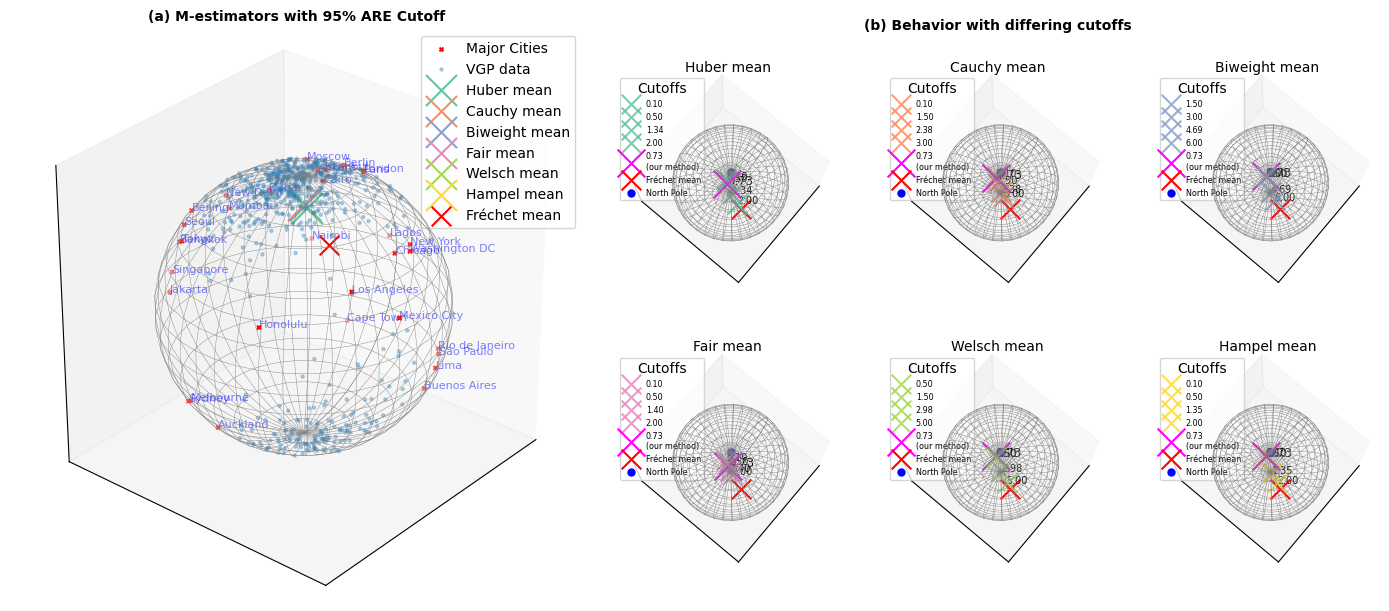

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)

# --- dummy data (원하는 데이터로 교체) ---
# 파라미터 그리드
u = np.linspace(0, 2*np.pi, 40)   # 경도
v = np.linspace(0, np.pi, 20)     # 위도
uu, vv = np.meshgrid(u, v)

# 단위원 구
x = np.cos(uu) * np.sin(vv)
y = np.sin(uu) * np.sin(vv)
z = np.cos(vv)

# --- figure / layout ---
fig = plt.figure(figsize=(14, 6), constrained_layout=True)

# 좌(큰 1개) / 우(2x3 6개)
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[0.8, 1.0])  # 왼쪽을 더 넓게

# 왼쪽 큰 3D
ax_big = fig.add_subplot(gs[0, 0], projection="3d")

ax_big.scatter(points[:,0], points[:,1], points[:,2],
        c="red", s=8, label="Major Cities",marker='x')

# 도시 이름 라벨
for j, name in enumerate(names):
    ax_big.text(points[j,0], points[j,1], points[j,2],
            name, fontsize=8, color="blue",alpha=0.5)

# 와이어프레임: 면을 칠하지 않고 선만
ax_big.plot_wireframe(x, y, z, linewidth=0.3, rstride=1, cstride=1, color='gray')
# ax.scatter(sites[:,0],sites[:,1],sites[:,2],s=2)
# ax.scatter(vgps_sites[:,0],vgps_sites[:,1],vgps_sites[:,2],s=3,label='Sites_df',alpha=0.3)
# ax.scatter(vgp1[:,0],vgp1[:,1],vgp1[:,2],s=3,alpha=0.5,label='VGP_orig')
# ax.scatter(vgp_cal[:,0],vgp_cal[:,1],vgp_cal[:,2],s=5,alpha=0.5,label='VGP_cal')
ax_big.scatter(vgp_df[:,0],vgp_df[:,1],vgp_df[:,2],s=5,alpha=0.3,label='VGP data')
for m_est,(cutoffs,ix,col) in mest_meta.items():
    c = cutoffs[ix]
    m_est_ = m_est[0].upper()+m_est[1:]
    ax_big.scatter(*m_ests[m_est][c].estimate_.x,s=500,alpha=1,color=col,marker='x',label=f'{m_est_} mean')
ax_big.scatter(*fm.estimate_.x,s=200,alpha=1,marker='x',c='red',label='Fréchet mean')
ax_big.set_box_aspect([1,1,1])
ax_big.set_title("(a) M-estimators with 95% ARE Cutoff",fontsize='medium',fontweight="bold")
ax_big.set_xticks([])
ax_big.set_yticks([])
ax_big.set_zticks([])
ax_big.legend()
ax_big.view_init(elev=30, azim=220) 

# 오른쪽 2x3 sub-grid
# gs_right = gs[0, 1].subgridspec(nrows=2, ncols=3, wspace=0.05, hspace=-1)
gs_right = gs[0, 1].subgridspec(
    nrows=3, ncols=3,
    height_ratios=[0.12, 1, 1],   # 맨 위를 제목용으로 얇게
    wspace=0.05, hspace=-1
)

# 제목용 축(가짜 axis) 만들고 span
ax_right_title = fig.add_subplot(gs_right[0, :])
ax_right_title.axis("off")
ax_right_title.text(0.5, 0.5, "(b) Behavior with differing cutoffs", ha="center", va="center",
                    fontsize='medium', fontweight="bold")


axs = []
for ixx,(m_est,(cutoffs,ix,col)) in enumerate(mest_meta.items()):
# for i in range(2):
#     for j in range(3):
    i,j = ixx//3+1 , ixx%3
    ax = fig.add_subplot(gs_right[i, j], projection="3d")
    axs.append(ax)

    # --- 각 작은 플롯에 내용 채우기 (예시) ---
#     # 도시 점 찍기
#     ax.scatter(points[:,0], points[:,1], points[:,2],
#                 c="red", s=8, label="Major Cities",marker='x')

#     # 도시 이름 라벨
#     for j, name in enumerate(names):
#         ax.text(points[j,0], points[j,1], points[j,2],
#                 name, fontsize=8, color="blue",alpha=0.5)
    
    # 와이어프레임: 면을 칠하지 않고 선만
    ax.plot_wireframe(x, y, z, linewidth=0.3, rstride=1, cstride=1, color='gray')
    # ax.scatter(sites[:,0],sites[:,1],sites[:,2],s=2)
    # ax.scatter(vgps_sites[:,0],vgps_sites[:,1],vgps_sites[:,2],s=3,label='Sites_df',alpha=0.3)
    # ax.scatter(vgp1[:,0],vgp1[:,1],vgp1[:,2],s=3,alpha=0.5,label='VGP_orig')
    # ax.scatter(vgp_cal[:,0],vgp_cal[:,1],vgp_cal[:,2],s=5,alpha=0.5,label='VGP_cal')
    #ax.scatter(vgp_df[:,0],vgp_df[:,1],vgp_df[:,2],s=2,alpha=0.055,label='VGP data')
    m_est_ = m_est[0].upper()+m_est[1:]
    for c in cutoffs[::2]:
        if c==99:
            #ax.scatter(*m_ests[m_est][c].estimate_.x,s=300,alpha=1,#(c**(1/2)/(np.max(cutoffs)**(1/2)))
            #    marker='x',label=f'{cutoff_:.2f}(our method)',c='magenta')
            #ax.text(*m_ests[m_est][c].estimate_.x,s=f'{cutoff_:.2f}',fontsize='x-small')
            pass
        else:
            ax.scatter(*m_ests[m_est][c].estimate_.x,s=200,alpha=0.85,#(c**(1/2)/(np.max(cutoffs)**(1/2)))
                marker='x',label=f'{c:.2f}',c=col)
            ax.text(*m_ests[m_est][c].estimate_.x,s=f'{c:.2f}',fontsize='x-small')
    
    ax.scatter(*m_ests[m_est][99].estimate_.x,s=400,alpha=1,#(c**(1/2)/(np.max(cutoffs)**(1/2)))
        marker='x',label=f'{cutoff_:.2f}\n(our method)',c='magenta')
    ax.text(*m_ests[m_est][99].estimate_.x,s=f'{cutoff_:.2f}',fontsize='small')
    ax.scatter(*fm.estimate_.x,s=200,alpha=1,marker='x',c='red',label='Fréchet mean')
    ax.scatter(*np.array([0,0,1]),s=25,alpha=1,marker='o',c='blue',label='North Pole')
    
    ax.set_box_aspect([1,1,1])
    # ax.set_axis_off()  # 축 제거(선택)
    ax.legend(fontsize='xx-small',title='Cutoffs',loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize='xx-small')
    ax.view_init(elev=80, azim=220) 
    ax.set_title(f"{m_est_} mean", pad=2,fontsize='medium')

    # 작은 플롯은 축 라벨/틱 간소화(원하면 삭제)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

#plt.tight_layout()
plt.savefig('../plots_realdata/paleomagnetic_vgp_m_estimators.png')
plt.savefig('../plots_realdata/realdata_submit/paleomagnetic_vgp_m_estimators.pdf')
plt.savefig('../plots_realdata/realdata_submit/paleomagnetic_vgp_m_estimators.eps')
plt.show()